<a href="https://colab.research.google.com/github/kentokpara/COMP6999-001/blob/main/MRP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Waste Manageement and Recyling with ML**

---



In [ ]:
#@title Import relevant modules
import numpy as np
import os
import PIL
import PIL.Image
!pip install tensorflow
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import zipfile
from pathlib import Path
import glob
import pandas as pd
!pip install opencv-python
import cv2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
print(tf.__version__)

2.9.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
local_zip = '/content/drive/MyDrive/Colab Notebooks/Trashnet.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/Colab-Notebooks')
zip_ref.close()

In [ ]:
base_dir = '/Colab-Notebooks/dataset-resized'


In [ ]:
try:
   import splitfolders as sf
except ModuleNotFoundError:
  !pip install split-folders
  import splitfolders as sf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
input_folder = base_dir
output = '/Colab-Notebooks/Split'
 #where you want the split datasets saved
sf.ratio(input_folder, output=output, seed=42, ratio=(.8, .2)) 
# ratio of split are in order of train/val/ only.

base_dir = output

Copying files: 2527 files [00:00, 6994.92 files/s]


In [ ]:
train_dataset = "/Colab-Notebooks/Split/train"
val_dataset = "/Colab-Notebooks/Split/val"


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dataset,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=50,
    image_size=(180, 180),
)

Found 2019 files belonging to 6 classes.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dataset,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=50,
    image_size=(180, 180),
    shuffle=True,
)

Found 508 files belonging to 6 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


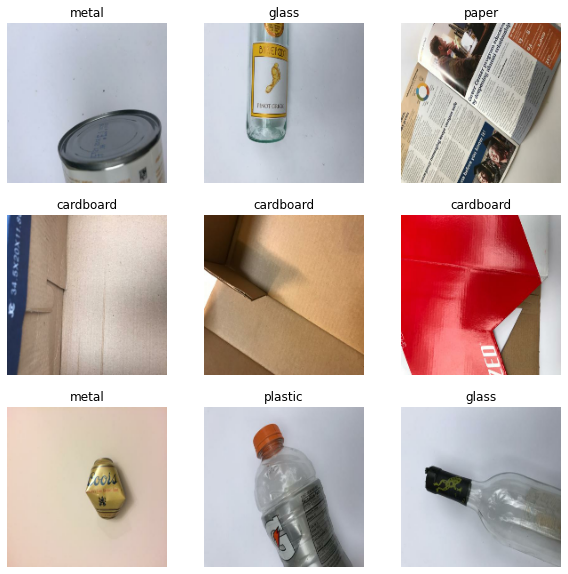

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.7 MB/s 


In [ ]:
for images, labels in val_ds:
  x_test = images
  y_test = labels

print(x_test.shape)
print(y_test.shape)

(8, 180, 180, 3)
(8,)


In [ ]:
for images, labels in train_ds:
  x_train = images
  y_train = labels

print(x_train.shape)
print(y_train.shape)

(19, 180, 180, 3)
(19,)


In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.Normalization(),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomWidth(0.2),
        tf.keras.layers.RandomHeight(0.2),
    ]
)

# Setting the state of the normalization layer

In [ ]:
def create_encoder():
    Xcept = tf.keras.applications.Xception(
        include_top=False, weights=None, input_shape=(180,180,3), pooling="avg"
    )

    inputs = tf.keras.Input(shape=(180,180,3))
    augmented = data_augmentation(inputs)
    outputs = Xcept(augmented)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="Xcept-encoder")
    return model


encoder = create_encoder()
encoder.summary()

learning_rate = 0.0001
batch_size = 100
hidden_units = 2048
projection_units = 128
num_epochs = 40
dropout_rate = 0.4
temperature = 0.07

Model: "Xcept-encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       7         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
Total params: 20,861,487
Trainable params: 20,806,952
Non-trainable params: 54,535
_________________________________________________________________


In [ ]:
def create_classifier(encoder, trainable=True):

    for layer in encoder.layers:
        layer.trainable = trainable

    inputs = tf.keras.Input(shape=(180,180,3))
    features = encoder(inputs)
    features = tf.keras.layers.Dropout(dropout_rate)(features)
    features = tf.keras.layers.Dense(hidden_units, activation="relu")(features)
    features = tf.keras.layers.Dropout(dropout_rate)(features)
    outputs = tf.keras.layers.Dense(6, activation="softmax")(features)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="Xcept-classifier")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )
    return model

In [ ]:
encoder = create_encoder()
classifier = create_classifier(encoder)
classifier.summary()

history = classifier.fit(train_ds, batch_size=batch_size, epochs=num_epochs)



Model: "Xcept-classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 Xcept-encoder (Functional)  (None, 2048)              20861487  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 6)                 12294     
                                                                 
Total params: 25,070,133
Trainable params: 25,015,

In [ ]:
accuracy = classifier.evaluate(val_ds)[1]

print(f"Test accuracy: {round(accuracy * 100, 2)}%")

11/11 [==============================] - 1s 41ms/step - loss: 0.7212 - sparse_categorical_accuracy: 0.8012
Test accuracy: 80.12%


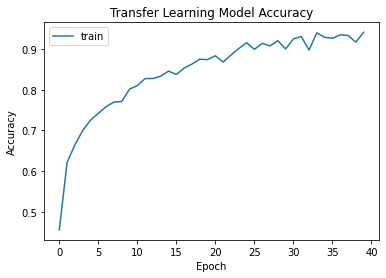

In [ ]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.title('Transfer Learning Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train'], loc='upper left')
plt.show()

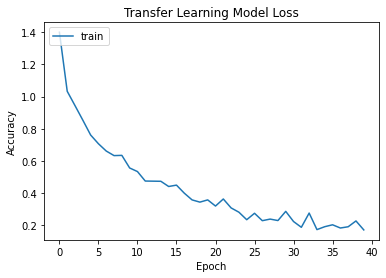

In [ ]:
plt.plot(history.history['loss'])
plt.title('Transfer Learning Model Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
import tensorflow_addons as tfa

In [ ]:
class SupervisedContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)


def add_projection_head(encoder):
    inputs = tf.keras.Input(shape=(180,180,3))
    features = encoder(inputs)
    outputs = tf.keras.layers.Dense(projection_units, activation="relu")(features)
    model = tf.keras.Model(
        inputs=inputs, outputs=outputs, name="encoder_with_projection-head"
    )
    return model

In [ ]:
encoder = create_encoder()

encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)

encoder_with_projection_head.summary()

history1_Loss = encoder_with_projection_head.fit(
    train_ds, batch_size=batch_size, epochs=num_epochs
)

Model: "encoder_with_projection-head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 Xcept-encoder (Functional)  (None, 2048)              20861487  
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
Total params: 21,123,759
Trainable params: 21,069,224
Non-trainable params: 54,535
_________________________________________________________________
Epoch 1/40
41/41 [==============================] - 24s 438ms/step - loss: 3.6617
Epoch 2/40
41/41 [==============================] - 17s 403ms/step - loss: 3.4942
Epoch 3/40
41/41 [==============================] - 16s 391ms/step - loss: 3.4412
Epoch 4/40
41/41 [=====================

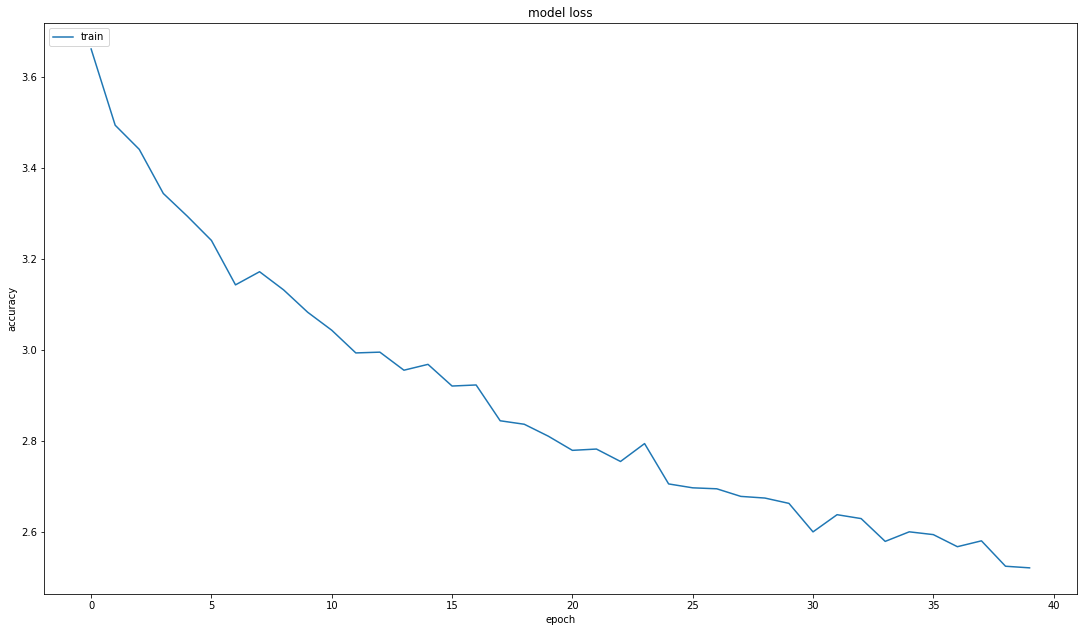

In [ ]:
plt.plot(history1_Loss.history['loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

In [ ]:
classifier = create_classifier(encoder, trainable=False)

history1 = classifier.fit(train_ds, batch_size=batch_size, epochs=num_epochs)

accuracy = classifier.evaluate(val_ds)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

Epoch 1/40
41/41 [==============================] - 6s 76ms/step - loss: 0.4845 - sparse_categorical_accuracy: 0.8554
Epoch 2/40
41/41 [==============================] - 3s 67ms/step - loss: 0.1434 - sparse_categorical_accuracy: 0.9643
Epoch 3/40
41/41 [==============================] - 3s 65ms/step - loss: 0.1179 - sparse_categorical_accuracy: 0.9614
Epoch 4/40
41/41 [==============================] - 3s 76ms/step - loss: 0.1197 - sparse_categorical_accuracy: 0.9653
Epoch 5/40
41/41 [==============================] - 3s 70ms/step - loss: 0.1066 - sparse_categorical_accuracy: 0.9668
Epoch 6/40
41/41 [==============================] - 3s 65ms/step - loss: 0.0940 - sparse_categorical_accuracy: 0.9698
Epoch 7/40
41/41 [==============================] - 3s 66ms/step - loss: 0.1131 - sparse_categorical_accuracy: 0.9619
Epoch 8/40
41/41 [==============================] - 3s 60ms/step - loss: 0.0940 - sparse_categorical_accuracy: 0.9713
Epoch 9/40
41/41 [==============================] - 3s 6

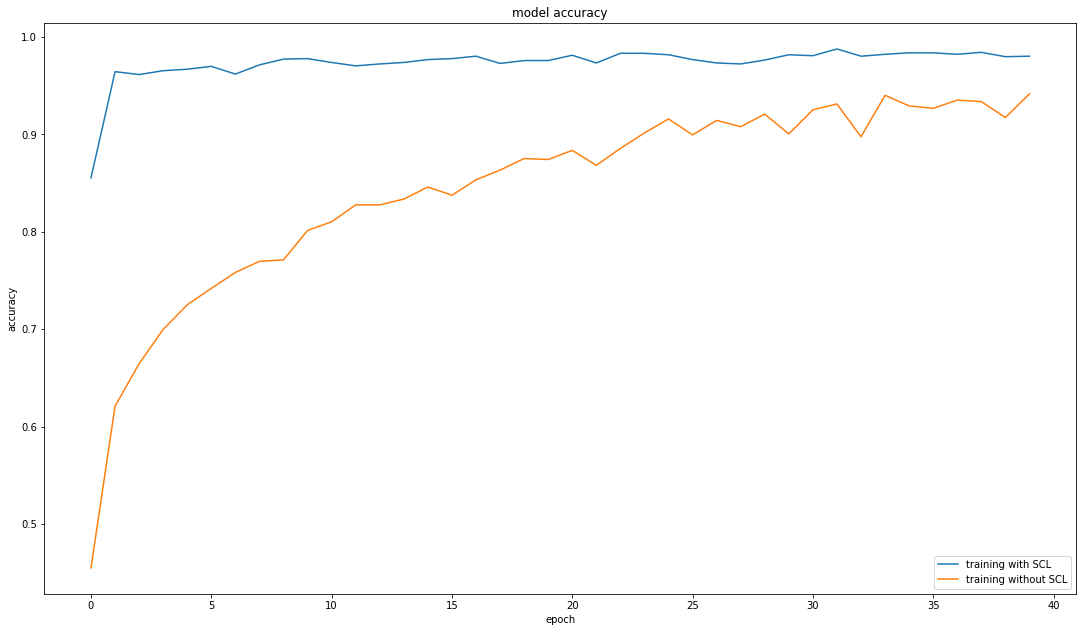

In [ ]:
plt.plot(history1.history['sparse_categorical_accuracy'])
plt.plot(history.history['sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training with SCL','training without SCL'], loc='lower right')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

In [ ]:
# Pillow
import PIL
from PIL import Image,ImageEnhance,ImageFilter

import numpy as np
import matplotlib.pyplot as plt
import glob, os
import re
import numpy
import pathlib as Path
import os.path
from os import path
import shutil
from random import randrange, uniform


In [ ]:
shutil.rmtree('/Colab-Notebooks/Aug_Test/', ignore_errors=True)

In [ ]:
if path.isdir('/Colab-Notebooks/Aug_Test/'):
  print('Path exists.....skipping')
else:
  os.mkdir('/Colab-Notebooks/Aug_Test/')

In [ ]:
import cv2
import os
from PIL import ImageFilter

def load_images_from_folder(folder,class_names):
    global data
    data = []
    for subdir, dirs, files in os.walk(folder):
      for file in files:
        img = Image.open(os.path.join(subdir, file)).convert('RGB')
        img = img.resize((180, 180))
        #Random Generator
        x = uniform(0.2, 1.8)#where 0 is black and 2 is white
        #Preprocessing-Random Brightness
        color_enhancer = ImageEnhance.Brightness(img)
        img_EN = color_enhancer.enhance(x)

        #im_Ed = color_enhancer.enhance(.4)
        #data.extend([img_EN,im_Ed])
        open_cv_img = numpy.array(img)
        open_cv_img_en = numpy.array(img_EN)
        #open_cv_img_ed = numpy.array(im_Ed)
        open_cv_img = cv2.cvtColor(open_cv_img, cv2.COLOR_RGB2BGR)
        open_cv_img_en = cv2.cvtColor(open_cv_img_en, cv2.COLOR_RGB2BGR)
        #open_cv_img_ed = cv2.cvtColor(open_cv_img_ed, cv2.COLOR_RGB2BGR)
        data.extend([open_cv_img,open_cv_img_en])
          # Convert RGB to BGR 
        for a in range (0,(len(data))):
            #data[a].save(save_path /  str(count)+'.jpg')
            #path = os.path.join('/Colab-Notebooks/Aug_Test/',class_names)
            base_path = '/Colab-Notebooks/Aug_Test/'
            if path.isdir(os.path.join(base_path,class_names)):
              cv2.imwrite(base_path + class_names + f'/image_{a}.png',data[a])
            else:
              os.mkdir(os.path.join(base_path,class_names))
              cv2.imwrite(base_path + class_names + f'/image_{a}.png',data[a])
            #print(path + f'/image_{a}.png')
            #cv2.imwrite(f'/Colab-Notebooks/Test3/image_{a}.png',data[a])

    return

In [ ]:
 #data.extend([img_EN,im_Ed])
       

In [ ]:
#@title Default title text
load_images_from_folder("/Colab-Notebooks/Split/train/cardboard",'cardboard')


In [ ]:
load_images_from_folder("/Colab-Notebooks/Split/train/glass",'glass')

In [ ]:
load_images_from_folder("/Colab-Notebooks/Split/train/metal",'metal')

In [ ]:
load_images_from_folder("/Colab-Notebooks/Split/train/paper",'paper')


In [ ]:
load_images_from_folder("/Colab-Notebooks/Split/train/trash",'trash')


In [ ]:
load_images_from_folder("/Colab-Notebooks/Split/train/plastic",'plastic')

In [ ]:
Test = '/Colab-Notebooks/Aug_Test/'

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    Test,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    image_size=(180,180),
    batch_size=32,
    shuffle=True,
    seed=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

In [ ]:
encoder = create_encoder()

encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)

encoder_with_projection_head.summary()

history_mod_loss = encoder_with_projection_head.fit(
    train_ds, batch_size=batch_size, epochs=num_epochs
)

Model: "encoder_with_projection-head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 Xcept-encoder (Functional)  (None, 2048)              20861487  
                                                                 
 dense_5 (Dense)             (None, 128)               262272    
                                                                 
Total params: 21,123,759
Trainable params: 21,069,224
Non-trainable params: 54,535
_________________________________________________________________
Epoch 1/40
127/127 [==============================] - 78s 565ms/step - loss: 3.2336
Epoch 2/40
127/127 [==============================] - 61s 478ms/step - loss: 3.1183
Epoch 3/40
127/127 [==============================] - 51s 402ms/step - loss: 3.0654
Epoch 4/40
127/127 [=============

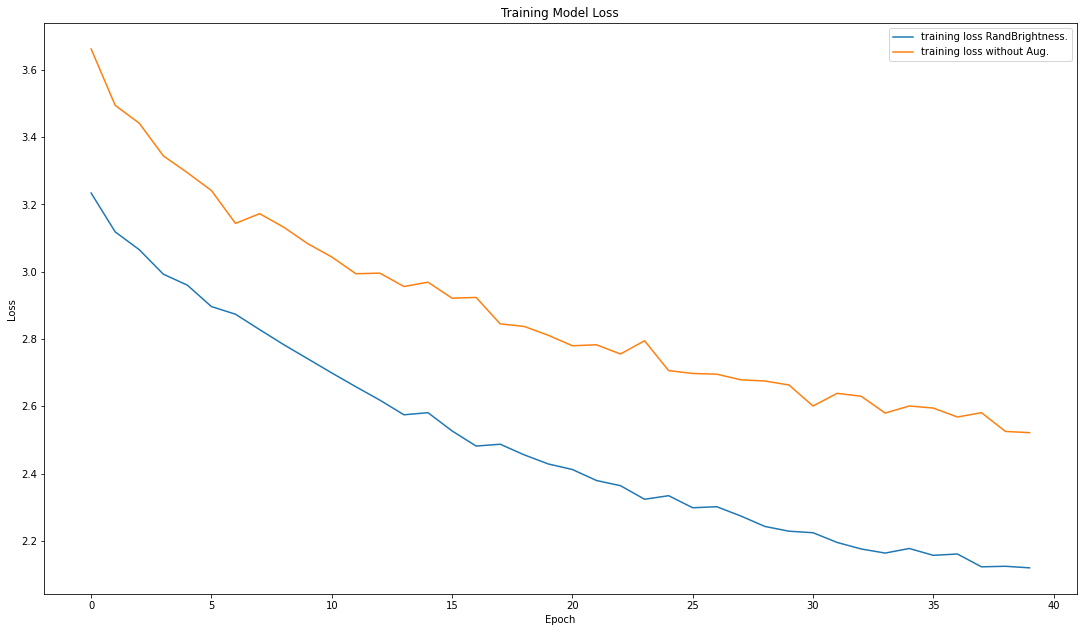

In [ ]:
plt.plot(history_mod_loss.history['loss'])
plt.plot(history1_Loss.history['loss'])
#plt.plot(history1.history['sparse_categorical_accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('Training Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training loss RandBrightness.','training loss without Aug.' ], loc='upper right')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

In [ ]:
classifier = create_classifier(encoder, trainable=False)

history_mod = classifier.fit(train_ds, batch_size=batch_size, epochs=num_epochs)


Epoch 1/40
127/127 [==============================] - 8s 38ms/step - loss: 0.3329 - sparse_categorical_accuracy: 0.8908
Epoch 2/40
127/127 [==============================] - 5s 40ms/step - loss: 0.2167 - sparse_categorical_accuracy: 0.9274
Epoch 3/40
127/127 [==============================] - 5s 39ms/step - loss: 0.2091 - sparse_categorical_accuracy: 0.9284
Epoch 4/40
127/127 [==============================] - 5s 38ms/step - loss: 0.1992 - sparse_categorical_accuracy: 0.9316
Epoch 5/40
127/127 [==============================] - 5s 39ms/step - loss: 0.2054 - sparse_categorical_accuracy: 0.9267
Epoch 6/40
127/127 [==============================] - 5s 39ms/step - loss: 0.1764 - sparse_categorical_accuracy: 0.9428
Epoch 7/40
127/127 [==============================] - 5s 38ms/step - loss: 0.1892 - sparse_categorical_accuracy: 0.9368
Epoch 8/40
127/127 [==============================] - 5s 38ms/step - loss: 0.1785 - sparse_categorical_accuracy: 0.9408
Epoch 9/40
127/127 [====================

In [ ]:
accuracy = classifier.evaluate(val_ds)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

11/11 [==============================] - 0s 30ms/step - loss: 0.6887 - sparse_categorical_accuracy: 0.8051
Test accuracy: 80.51%


In [ ]:
plt.plot(history_mod.history['sparse_categorical_accuracy'])
plt.plot(history1.history['sparse_categorical_accuracy'])
plt.plot(history.history['sparse_categorical_accuracy'])
plt.title('training model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training with SCL-RandBrightness.','training with SCL','training without SCL'], loc='lower right')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

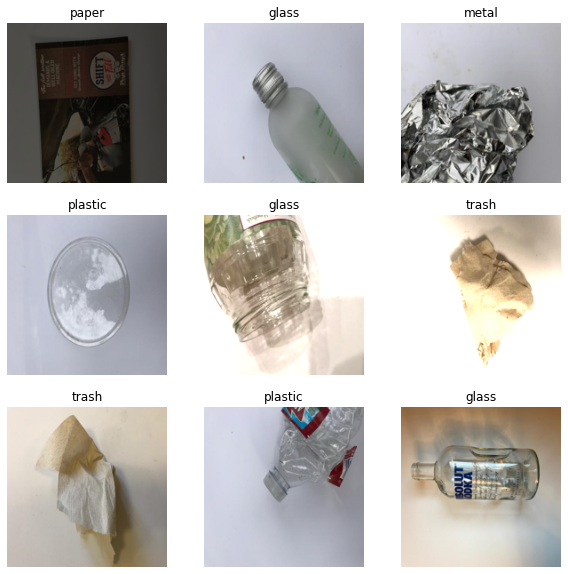

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
shutil.rmtree('/Colab-Notebooks/Augc_Test/', ignore_errors=True)

In [ ]:
if path.isdir('/Colab-Notebooks/Augc_Test/'):
  print('Path exists.....skipping')
else:
  os.mkdir('/Colab-Notebooks/Augc_Test/')

In [ ]:
import cv2
import os
from PIL import ImageFilter

def load_images_from_folder(folder,class_names):
    global data
    data = []
    for subdir, dirs, files in os.walk(folder):
      for file in files:
        img = Image.open(os.path.join(subdir, file)).convert('RGB')
        img = img.resize((180, 180))
        #Random Generator
        x = uniform(0.0, 1.0)
        #Preprocessing-Random Contrast
        color_enhancer = ImageEnhance.Contrast(img)
        img_EN = color_enhancer.enhance(x)

        #im_Ed = color_enhancer.enhance(.4)
        #data.extend([img_EN,im_Ed])
        open_cv_img = numpy.array(img)
        open_cv_img_en = numpy.array(img_EN)
        #open_cv_img_ed = numpy.array(im_Ed)
        open_cv_img = cv2.cvtColor(open_cv_img, cv2.COLOR_RGB2BGR)
        open_cv_img_en = cv2.cvtColor(open_cv_img_en, cv2.COLOR_RGB2BGR)
        #open_cv_img_ed = cv2.cvtColor(open_cv_img_ed, cv2.COLOR_RGB2BGR)
        data.extend([open_cv_img,open_cv_img_en])
          # Convert RGB to BGR 
        for a in range (0,(len(data))):
            #data[a].save(save_path /  str(count)+'.jpg')
            #path = os.path.join('/Colab-Notebooks/Aug_Test/',class_names)
            base_path = '/Colab-Notebooks/Augc_Test/'
            if path.isdir(os.path.join(base_path,class_names)):
              cv2.imwrite(base_path + class_names + f'/image_{a}.png',data[a])
            else:
              os.mkdir(os.path.join(base_path,class_names))
              cv2.imwrite(base_path + class_names + f'/image_{a}.png',data[a])
            #print(path + f'/image_{a}.png')
            #cv2.imwrite(f'/Colab-Notebooks/Test3/image_{a}.png',data[a])

    return

In [ ]:
load_images_from_folder("/Colab-Notebooks/Split/train/cardboard",'cardboard')
load_images_from_folder("/Colab-Notebooks/Split/train/glass",'glass')
load_images_from_folder("/Colab-Notebooks/Split/train/metal",'metal')
load_images_from_folder("/Colab-Notebooks/Split/train/paper",'paper')
load_images_from_folder("/Colab-Notebooks/Split/train/trash",'trash')
load_images_from_folder("/Colab-Notebooks/Split/train/plastic",'plastic')


In [ ]:
Test1 = '/Colab-Notebooks/Augc_Test/'

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    Test1,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    image_size=(180,180),
    batch_size=32,
    shuffle=True,
    seed=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 4038 files belonging to 6 classes.


In [ ]:
encoder = create_encoder()

encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)

encoder_with_projection_head.summary()

history_mod_loss1 = encoder_with_projection_head.fit(
    train_ds, batch_size=batch_size, epochs=num_epochs
)

Model: "encoder_with_projection-head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 Xcept-encoder (Functional)  (None, 2048)              20861487  
                                                                 
 dense_10 (Dense)            (None, 128)               262272    
                                                                 
Total params: 21,123,759
Trainable params: 21,069,224
Non-trainable params: 54,535
_________________________________________________________________
Epoch 1/40
127/127 [==============================] - 32s 213ms/step - loss: 3.2669
Epoch 2/40
127/127 [==============================] - 27s 214ms/step - loss: 3.1456
Epoch 3/40
127/127 [==============================] - 27s 211ms/step - loss: 3.0938
Epoch 4/40
127/127 [=============

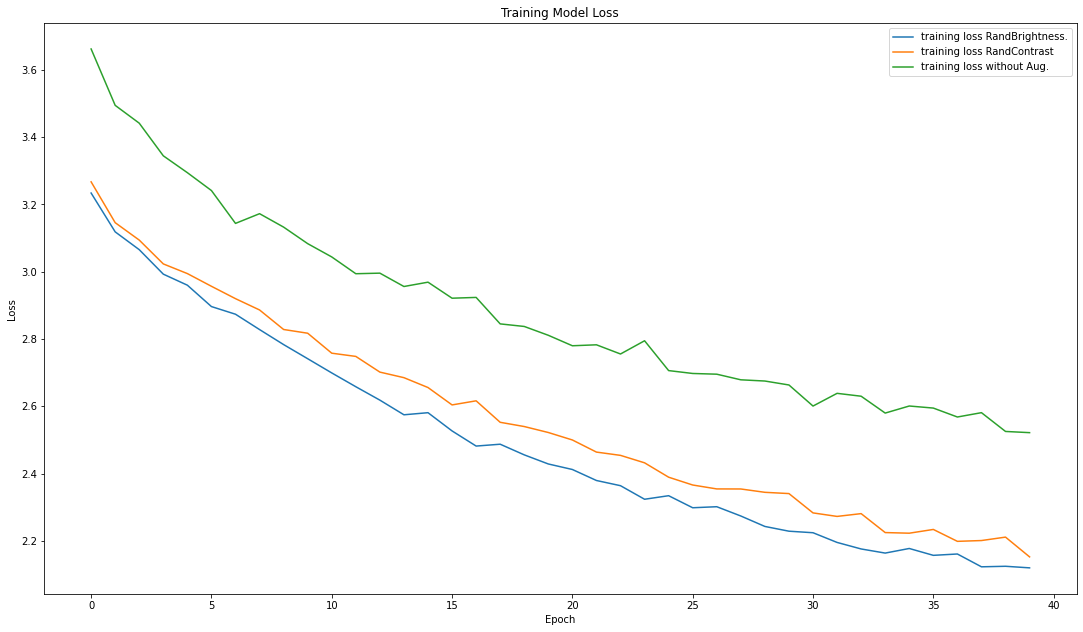

In [ ]:
plt.plot(history_mod_loss.history['loss'])
plt.plot(history_mod_loss1.history['loss'])
plt.plot(history1_Loss.history['loss'])
#plt.plot(history1.history['sparse_categorical_accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('Training Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training loss RandBrightness.','training loss RandContrast','training loss without Aug.' ], loc='upper right')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

In [ ]:
classifier = create_classifier(encoder, trainable=False)

history_mod1 = classifier.fit(train_ds, batch_size=batch_size, epochs=num_epochs)

accuracy = classifier.evaluate(val_ds)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

Epoch 1/40
127/127 [==============================] - 8s 37ms/step - loss: 0.4159 - sparse_categorical_accuracy: 0.8653
Epoch 2/40
127/127 [==============================] - 5s 37ms/step - loss: 0.3123 - sparse_categorical_accuracy: 0.8992
Epoch 3/40
127/127 [==============================] - 5s 38ms/step - loss: 0.2972 - sparse_categorical_accuracy: 0.9017
Epoch 4/40
127/127 [==============================] - 5s 37ms/step - loss: 0.2776 - sparse_categorical_accuracy: 0.9094
Epoch 5/40
127/127 [==============================] - 5s 37ms/step - loss: 0.2856 - sparse_categorical_accuracy: 0.9044
Epoch 6/40
127/127 [==============================] - 5s 37ms/step - loss: 0.2696 - sparse_categorical_accuracy: 0.9086
Epoch 7/40
127/127 [==============================] - 5s 37ms/step - loss: 0.2631 - sparse_categorical_accuracy: 0.9104
Epoch 8/40
127/127 [==============================] - 5s 38ms/step - loss: 0.2557 - sparse_categorical_accuracy: 0.9136
Epoch 9/40
127/127 [====================

In [ ]:
accuracy = classifier.evaluate(val_ds)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

11/11 [==============================] - 0s 28ms/step - loss: 0.6842 - sparse_categorical_accuracy: 0.8189
Test accuracy: 81.89%


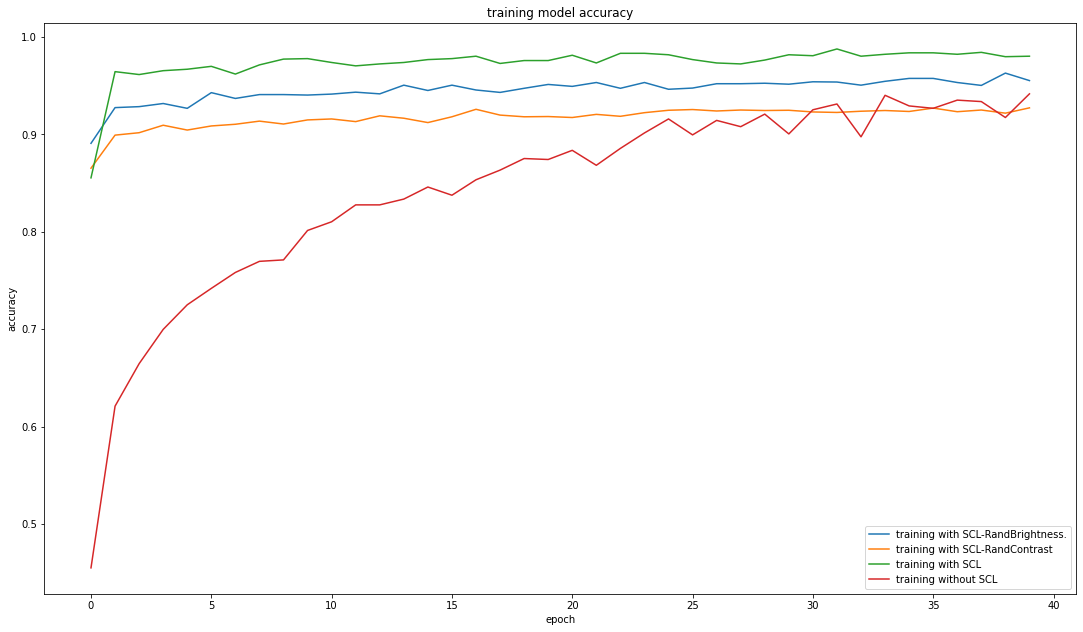

In [ ]:
plt.plot(history_mod.history['sparse_categorical_accuracy'])
plt.plot(history_mod1.history['sparse_categorical_accuracy'])
#plt.plot(history_mod2.history['sparse_categorical_accuracy'])
plt.plot(history1.history['sparse_categorical_accuracy'])
plt.plot(history.history['sparse_categorical_accuracy'])
plt.title('training model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training with SCL-RandBrightness.','training with SCL-RandContrast','training with SCL','training without SCL'], loc='lower right')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

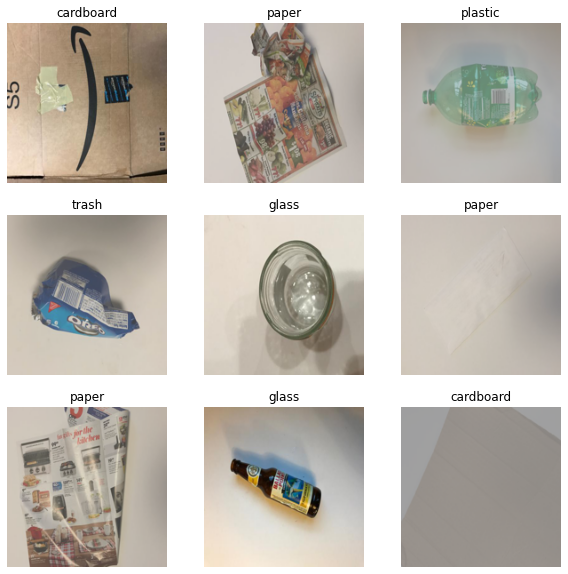

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
shutil.rmtree('/Colab-Notebooks/Augb_Test/', ignore_errors=True)

In [ ]:
if path.isdir('/Colab-Notebooks/Augb_Test/'):
  print('Path exists.....skipping')
else:
  os.mkdir('/Colab-Notebooks/Augb_Test/')

In [ ]:
import cv2
import os
from PIL import ImageFilter

def load_images_from_folder(folder,class_names):
    global data
    data = []
    for subdir, dirs, files in os.walk(folder):
      for file in files:
        img = Image.open(os.path.join(subdir, file)).convert('RGB')
        img = img.resize((180, 180))
        #Random Generator
        x = uniform(0.0, 2.0)
        #Preprocessing-Random Contrast
        color_enhancer = ImageEnhance.Sharpness(img)
        img_EN = color_enhancer.enhance(x)

        #im_Ed = color_enhancer.enhance(.4)
        #data.extend([img_EN,im_Ed])
        open_cv_img = numpy.array(img)
        open_cv_img_en = numpy.array(img_EN)
        #open_cv_img_ed = numpy.array(im_Ed)
        open_cv_img = cv2.cvtColor(open_cv_img, cv2.COLOR_RGB2BGR)
        open_cv_img_en = cv2.cvtColor(open_cv_img_en, cv2.COLOR_RGB2BGR)
        #open_cv_img_ed = cv2.cvtColor(open_cv_img_ed, cv2.COLOR_RGB2BGR)
        data.extend([open_cv_img,open_cv_img_en])
          # Convert RGB to BGR 
        for a in range (0,(len(data))):
            #data[a].save(save_path /  str(count)+'.jpg')
            #path = os.path.join('/Colab-Notebooks/Aug_Test/',class_names)
            base_path = '/Colab-Notebooks/Augb_Test/'
            if path.isdir(os.path.join(base_path,class_names)):
              cv2.imwrite(base_path + class_names + f'/image_{a}.png',data[a])
            else:
              os.mkdir(os.path.join(base_path,class_names))
              cv2.imwrite(base_path + class_names + f'/image_{a}.png',data[a])
            #print(path + f'/image_{a}.png')
            #cv2.imwrite(f'/Colab-Notebooks/Test3/image_{a}.png',data[a])

    return

In [ ]:
load_images_from_folder("/Colab-Notebooks/Split/train/cardboard",'cardboard')
load_images_from_folder("/Colab-Notebooks/Split/train/glass",'glass')
load_images_from_folder("/Colab-Notebooks/Split/train/metal",'metal')
load_images_from_folder("/Colab-Notebooks/Split/train/paper",'paper')
load_images_from_folder("/Colab-Notebooks/Split/train/trash",'trash')
load_images_from_folder("/Colab-Notebooks/Split/train/plastic",'plastic')

In [ ]:
Test2 = '/Colab-Notebooks/Augb_Test/'

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    Test2,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    image_size=(180,180),
    batch_size=32,
    shuffle=True,
    seed=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,)

Found 4038 files belonging to 6 classes.


In [ ]:
encoder = create_encoder()

encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)

encoder_with_projection_head.summary()

history_mod_loss2 = encoder_with_projection_head.fit(
    train_ds, batch_size=batch_size, epochs=num_epochs
)

Model: "encoder_with_projection-head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 Xcept-encoder (Functional)  (None, 2048)              20861487  
                                                                 
 dense_13 (Dense)            (None, 128)               262272    
                                                                 
Total params: 21,123,759
Trainable params: 21,069,224
Non-trainable params: 54,535
_________________________________________________________________
Epoch 1/40
127/127 [==============================] - 31s 201ms/step - loss: 3.0996
Epoch 2/40
127/127 [==============================] - 26s 201ms/step - loss: 2.9315
Epoch 3/40
127/127 [==============================] - 26s 206ms/step - loss: 2.8565
Epoch 4/40
127/127 [=============

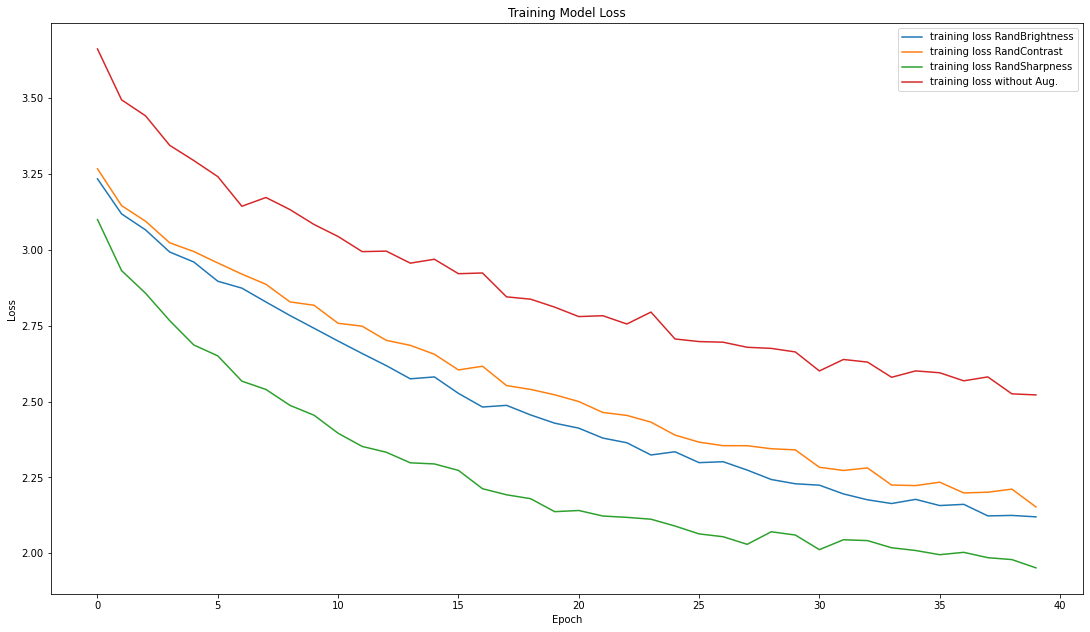

In [ ]:
plt.plot(history_mod_loss.history['loss'])
plt.plot(history_mod_loss1.history['loss'])
plt.plot(history_mod_loss2.history['loss'])
plt.plot(history1_Loss.history['loss'])
#plt.plot(history1.history['sparse_categorical_accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('Training Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training loss RandBrightness','training loss RandContrast','training loss RandSharpness','training loss without Aug.' ], loc='upper right')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

In [ ]:
classifier = create_classifier(encoder, trainable=False)

history_mod2 = classifier.fit(train_ds, batch_size=batch_size, epochs=num_epochs)

accuracy = classifier.evaluate(val_ds)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

Epoch 1/40
127/127 [==============================] - 8s 37ms/step - loss: 0.1484 - sparse_categorical_accuracy: 0.9589
Epoch 2/40
127/127 [==============================] - 5s 37ms/step - loss: 0.0429 - sparse_categorical_accuracy: 0.9879
Epoch 3/40
127/127 [==============================] - 5s 37ms/step - loss: 0.0434 - sparse_categorical_accuracy: 0.9861
Epoch 4/40
127/127 [==============================] - 5s 37ms/step - loss: 0.0367 - sparse_categorical_accuracy: 0.9891
Epoch 5/40
127/127 [==============================] - 5s 37ms/step - loss: 0.0339 - sparse_categorical_accuracy: 0.9884
Epoch 6/40
127/127 [==============================] - 5s 38ms/step - loss: 0.0323 - sparse_categorical_accuracy: 0.9906
Epoch 7/40
127/127 [==============================] - 5s 37ms/step - loss: 0.0360 - sparse_categorical_accuracy: 0.9889
Epoch 8/40
127/127 [==============================] - 5s 37ms/step - loss: 0.0314 - sparse_categorical_accuracy: 0.9894
Epoch 9/40
127/127 [====================

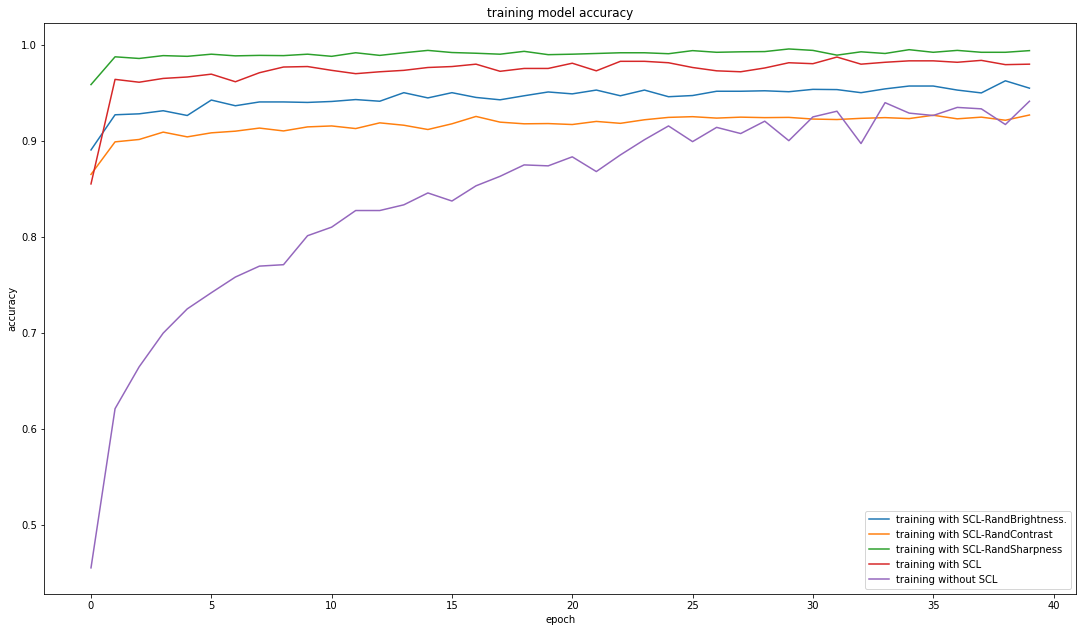

In [ ]:
plt.plot(history_mod.history['sparse_categorical_accuracy'])
plt.plot(history_mod1.history['sparse_categorical_accuracy'])
plt.plot(history_mod2.history['sparse_categorical_accuracy'])
plt.plot(history1.history['sparse_categorical_accuracy'])
plt.plot(history.history['sparse_categorical_accuracy'])
plt.title('training model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training with SCL-RandBrightness.','training with SCL-RandContrast','training with SCL-RandSharpness','training with SCL','training without SCL'], loc='lower right')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

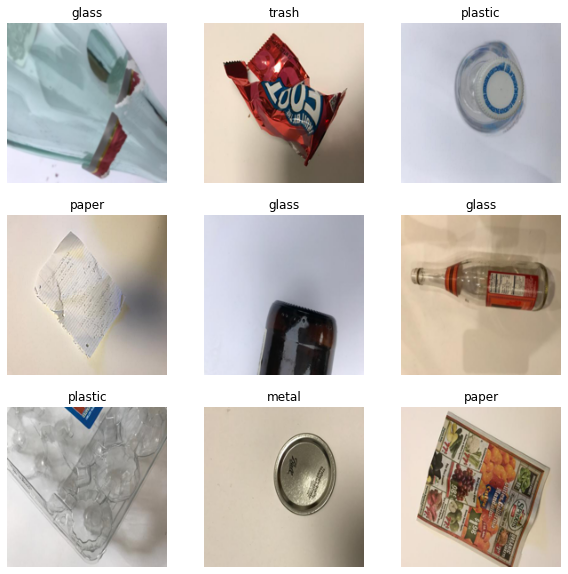

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")